# XGBOOST ON BRAIN - KPCA - ALL FEATURES

In [1]:
#Import packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#import xgboost
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

#import sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate 
#from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import *
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics

import shap

import os
import glob
import time

import  warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Preprocessing of data 

### Load data and Declare feature vector and target variable

In [2]:
df=pd.read_csv("/Users/justine_labory/Desktop/These_ANR/Latent_space_metabolomics/brain_project/BRAIN_KPCA_ON_ALLFEAT.csv")
X=df.drop("Label", axis=1)
y=df["Label"]

In [3]:
X.head()

,KPC1,KPC2
0,-0.854963,-2.351413e-18
1,9.069094,2.804757e-02
2,-1.950523,2.538165e-01
3,-0.375861,-2.323799e-03
4,-0.293537,-1.831756e-01


In [4]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Label, dtype: int64

### Run XGBoost model with cross validation

[[2 7]
 [5 8]]
0.45454545454545453
0.4188034188034188
0.5714285714285715
0.5333333333333333
0.6153846153846154
0.4188034188034188


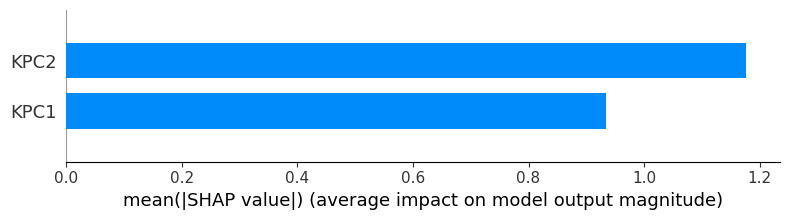

[[ 5  4]
 [10  3]]
0.36363636363636365
0.3931623931623932
0.3
0.42857142857142855
0.23076923076923078
0.39316239316239315


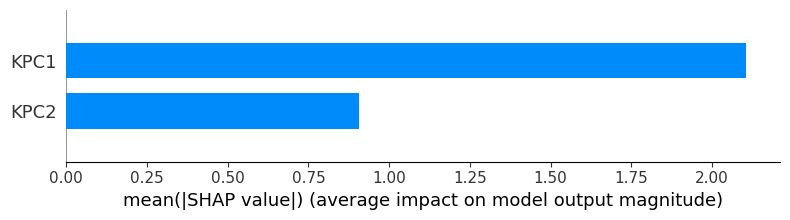

[[3 7]
 [7 5]]
0.36363636363636365
0.35833333333333334
0.4166666666666667
0.4166666666666667
0.4166666666666667
0.3583333333333334


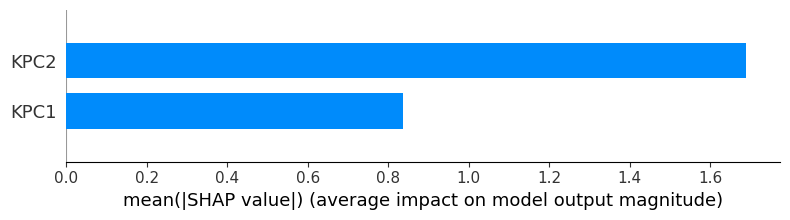

[[1 9]
 [4 8]]
0.4090909090909091
0.3833333333333333
0.5517241379310345
0.47058823529411764
0.6666666666666666
0.3833333333333333


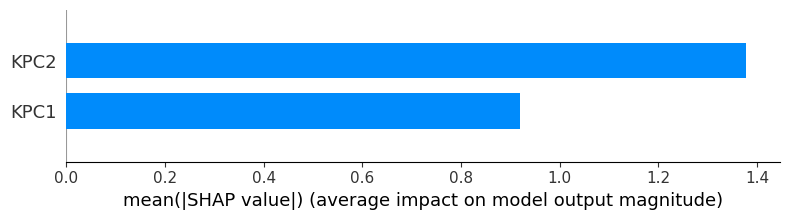

In [5]:
kfold = StratifiedKFold(n_splits=4)

lst_df = []

df_metrics = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1score',
                                   'roc_auc', 'specificity'],
                         index = ['fold1', 'fold2', 'fold3', 'fold4'])

cnt_fold = 1

for train_index,test_index in kfold.split(X,y):

    #X_train=X[train_index]
#     y_train=y[train_index]
#     X_test=X[test_index]
#     y_test=y[test_index]
    
    X_train=X.iloc[train_index]
    y_train=y.iloc[train_index]
    X_test=X.iloc[test_index]
    y_test=y.iloc[test_index]


    xgboost = XGBClassifier(seed=1234)

    xgboost = xgboost.fit(X_train,y_train)
    y_pred_proba = xgboost.predict_proba(X_test)[:,1]
    # # Get predicted probability
    y_pred = xgboost.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    spe= tn / (tn + fp)
    
    # try a way to append row in a dataframe to fill in the dataframe with metrics
    df_metrics.iloc[(cnt_fold -1)] = [acc, bal_acc, f1score, precision, recall, roc_auc, spe]
    
    print(acc)
    print(bal_acc)
    print(f1score)
    print(precision)
    print(recall)
    print(roc_auc)

#     Add feature importance

    #plot_importance(xgboost)
    #plt.show()
    
    #sorted_idx = xgboost.feature_importances_.argsort()
    #plt.barh(X.columns[sorted_idx],xgboost.feature_importances_[sorted_idx])
    #plt.show()

    explainer = shap.TreeExplainer(xgboost)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    #shap.summary_plot(shap_values, X_test)

    df = pd.DataFrame(
        {
            'true_label':y_test,
            'pred_label':y_pred,
            'pred_proba':y_pred_proba,
        }
        )
    df['fold']=cnt_fold
    #df['learning_rate']=learning_rate


    lst_df.append(df)


    cnt_fold+=1


#df_res_glob=pd.DataFrame(lst_df)

In [6]:
df_metrics.to_csv("/Users/justine_labory/Desktop/These_ANR/Latent_space_metabolomics_v3/metrics_table/brain/BRAIN_KPCA_sk.csv")
df_metrics

,accuracy,balanced_accuracy,precision,recall,f1score,roc_auc,specificity
fold1,0.454545,0.418803,0.571429,0.533333,0.615385,0.418803,0.222222
fold2,0.363636,0.393162,0.3,0.428571,0.230769,0.393162,0.555556
fold3,0.363636,0.358333,0.416667,0.416667,0.416667,0.358333,0.3
fold4,0.409091,0.383333,0.551724,0.470588,0.666667,0.383333,0.1


### Compute 95% CI

In [7]:
acc_ci= np.percentile(df_metrics["accuracy"], [2.5,97.5])
bal_acc_ci= np.percentile(df_metrics["balanced_accuracy"], [2.5,97.5])
precision_ci = np.percentile(df_metrics["precision"], [2.5,97.5])
recall_ci= np.percentile(df_metrics["recall"], [2.5,97.5])
f1_ci = np.percentile(df_metrics["f1score"], [2.5,97.5])
roc_auc_ci = np.percentile(df_metrics["roc_auc"], [2.5,97.5])
specificity_ci = np.percentile(df_metrics['specificity'], [2.5,97.5])

In [8]:
print(f'The confidence interval for accuracy is [{acc_ci[0]:.3f} ; {acc_ci[1]:.3f}]')
print(f'The confidence interval for balanced accucary is [{bal_acc_ci[0]:.3f} ; {bal_acc_ci[1]:.3f}]')
print(f'The confidence interval for precision is [{precision_ci[0]:.3f} ; {precision_ci[1]:.3f}]')
print(f'The confidence interval for recall is [{recall_ci[0]:.3f} ; {recall_ci[1]:.3f}]')
print(f'The confidence interval for F1 score is [{f1_ci[0]:.3f} ; {f1_ci[1]:.3f}]')
print(f'The confidence interval for ROC AUC score is [{roc_auc_ci[0]:.3f} ; {roc_auc_ci[1]:.3f}]')
print(f'The confidence interval for specificity score is [{specificity_ci[0]:.3f} ; {specificity_ci[1]:.3f}]')

The confidence interval for accuracy is [0.364 ; 0.451]
The confidence interval for balanced accucary is [0.360 ; 0.417]
The confidence interval for precision is [0.309 ; 0.570]
The confidence interval for recall is [0.418 ; 0.529]
The confidence interval for F1 score is [0.245 ; 0.663]
The confidence interval for ROC AUC score is [0.360 ; 0.417]
The confidence interval for specificity score is [0.109 ; 0.536]


### Compute mean and standard deviation

In [9]:
print(f'The mean accuracy is: {np.mean(df_metrics["accuracy"])*100:.1f} ({np.std(df_metrics["accuracy"])*100:.1f}) ')
print(f'The mean balanced accuracy is: {np.mean(df_metrics["balanced_accuracy"])*100:.1f} ({np.std(df_metrics["balanced_accuracy"])*100:.1f}) ')
print(f'The mean precision is: {np.mean(df_metrics["precision"])*100:.1f} ({np.std(df_metrics["precision"])*100:.1f}) ')
print(f'The mean recall is: {np.mean(df_metrics["recall"])*100:.1f} ({np.std(df_metrics["recall"])*100:.1f}) ')
print(f'The mean F1 score is: {np.mean(df_metrics["f1score"])*100:.1f} ({np.std(df_metrics["f1score"])*100:.1f}) ')
print(f'The mean ROC AUC is: {np.mean(df_metrics["roc_auc"])*100:.1f} ({np.std(df_metrics["roc_auc"])*100:.1f}) ')
print(f'The mean specificity is: {np.mean(df_metrics["specificity"])*100:.1f} ({np.std(df_metrics["specificity"])*100:.1f}) ')

The mean accuracy is: 39.8 (3.8) 
The mean balanced accuracy is: 38.8 (2.2) 
The mean precision is: 46.0 (11.0) 
The mean recall is: 46.2 (4.6) 
The mean F1 score is: 48.2 (17.3) 
The mean ROC AUC is: 38.8 (2.2) 
The mean specificity is: 29.4 (16.7) 
